## Lib Import

In [ ]:
!pip install xgboost

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import glob
import keras
import math
import tensorflow as tf
import xgboost
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dense,Flatten,Dropout
from keras.utils import plot_model
from sklearn import metrics
tf.__version__

'2.4.1'

In [ ]:
height = 160
width = 160

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Import & Data Overview

In [ ]:
!unzip /content/drive/MyDrive/dataset/anormal.zip -d /content/drive/MyDrive/X-ray_DS

Archive:  /content/drive/MyDrive/dataset/anormal.zip
   creating: /content/drive/MyDrive/X-ray_DS/anormal/
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_417.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_3429.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_1442.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_3130.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_593.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_2995.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_1904.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_1444.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_1102.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_714.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_1603.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_2613.png  
  inflating: /content/drive/MyDrive/X-ray_DS/anormal/1_3432.png  
  inflating: /content/drive/MyDrive/X-

In [ ]:
!unzip /content/drive/MyDrive/dataset/normal.zip -d /content/drive/MyDrive/X-ray_DS

Archive:  /content/drive/MyDrive/dataset/normal.zip
   creating: /content/drive/MyDrive/X-ray_DS/normal/
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_2276.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_043.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_3049.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_245.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_3425.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_3189.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_1474.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_724.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_2476.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_2762.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_021.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_2848.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_1747.png  
  inflating: /content/drive/MyDrive/X-ray_DS/normal/0_

In [ ]:
!ls /content/drive/MyDrive/X-ray_DS

anormal  normal


## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 7,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split=0.2
                                  )

training_set= train_datagen.flow_from_directory('/content/drive/MyDrive/X-ray_DS/',
                                                 target_size = (height, width),
                                                 batch_size = 128,
                                                 color_mode="rgb",
                                                 class_mode = 'binary',
                                                 subset = 'training',
                                                 classes=['anormal', 'normal'],
                                                 shuffle = True,
                                                seed=123
                                                 )
training_set_xgb= train_datagen.flow_from_directory('/content/drive/MyDrive/X-ray_DS/',
                                                 target_size = (height, width),
                                                 batch_size = 128,
                                                 color_mode="grayscale",
                                                 class_mode = 'binary',
                                                 subset = 'training',
                                                 classes=['anormal', 'normal'],
                                                shuffle=False
                                                 )

test_set= test_datagen.flow_from_directory('/content/drive/MyDrive/X-ray_DS/',
                                            target_size = (height,width),
                                            batch_size = 128,
                                            color_mode="rgb",
                                            class_mode = 'binary',
                                            subset = 'validation',
                                            classes=['anormal', 'normal'],
                                            shuffle = True,seed=123)

test_set_xgb= test_datagen.flow_from_directory('/content/drive/MyDrive/X-ray_DS/',
                                            target_size = (height,width),
                                            batch_size = 128,
                                            color_mode="grayscale",
                                            class_mode = 'binary',
                                            subset = 'validation',
                                            classes=['anormal', 'normal'],
                                            shuffle = False)


Found 5600 images belonging to 2 classes.
Found 5600 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.


## Data reading

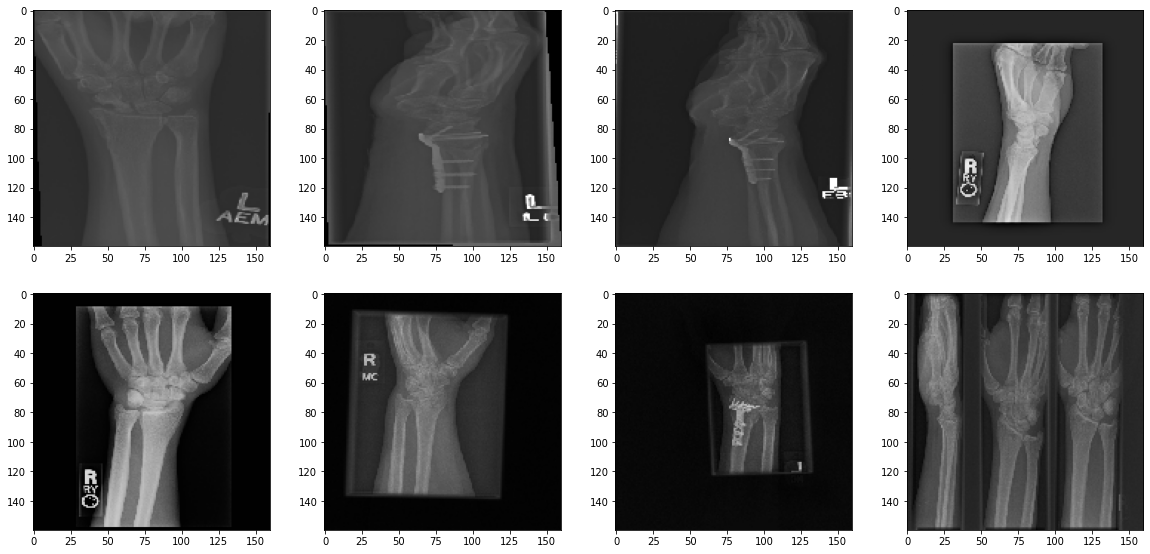

In [ ]:
for i in range(3):
    x1,y1 = next(test_set)
    y1_int = np.argmax(y1,axis=-1)
plt.figure(figsize=(20,20))
idx=1
for i in range(8):
    plt.subplot(4,4,idx)
    idx+=1
    plt.imshow(x1[i].reshape(160,160,3))
    

In [ ]:
len(training_set),len(test_set)

(44, 11)

In [ ]:
test_set.class_indices.keys()

dict_keys(['anormal', 'normal'])

## Functions

In [ ]:
def get_values(test):
  deneme=[]
  for i in range(test.__len__()):
       deneme.extend(test.__getitem__(i)[0])
  test_label=test.classes
  denemer=np.asarray(deneme)
  denemer=np.reshape(denemer,(test.samples,160*160))
 
  return denemer,test_label

In [ ]:
def get_key(val):
  for key,value in training_set_cnn.class_indices:
    if val == value:
      return key

In [ ]:
def prediction(x):
  veri=saved_model.predict(x.reshape(1,height,width,1)).argmax(axis=1)
  #durum=get_key(veri)
  return tahmin

In [ ]:
def sinif(pred):
  pred[pred>.5]=1
  pred[pred<=.5]=0
  return pred

In [ ]:
def metrik(pred,testy):

  acc = metrics.accuracy_score(testy, pred)
  prec = metrics.precision_score(testy, pred)
  recall = metrics.recall_score(testy, pred)
  f1 = metrics.f1_score(testy, pred)
  print('Accuracy: %f' % acc)
  print('precision: %f' % prec)
  print('recall: %f' % recall)
  print('f1 score: %f' % f1)
  print("Confusion Matris = \n {}".format(metrics.confusion_matrix(testy, pred)))
  return None

In [ ]:
def together_metrics(pred_cnn,pred_xgb,label):
  predict=np.zeros((len(label),1))
  pred_xgb=np.reshape(pred_xgb,(len(pred_xgb),1))
  pred_cnn=np.reshape(pred_cnn,(len(pred_cnn),1))
  label=np.reshape(label,(len(label),1))
  pred_cnn1=sinif(pred_cnn)
  pred_xgb1=sinif(pred_xgb)
  acc_cnn = metrics.accuracy_score(label, pred_cnn1)
  acc_xgb = metrics.accuracy_score(label, pred_xgb1)
  acc_plus=acc_cnn + acc_xgb
  for i in range (len(label)-1):
      predict[i]=((float (acc_cnn / acc_plus)* pred_cnn[i])+(float (acc_xgb / acc_plus)*pred_xgb[i]))
  predict=sinif(predict)
  metrik(predict,label)
  return predict,acc_cnn,acc_xgb,acc_plus


## Network

In [ ]:
image_count = 5592
BATCH_SIZE = 128
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VAL_STEP = np.ceil(1398/BATCH_SIZE)
print("Steps_per_epoch = ",STEPS_PER_EPOCH)
print("Val_Step = ",VAL_STEP)

Steps_per_epoch =  44.0
Val_Step =  11.0


In [ ]:
call_back = tf.keras.callbacks.EarlyStopping(monitor='accuracy')

In [ ]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(height,width,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

#model.add(Dropout(0.01))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0

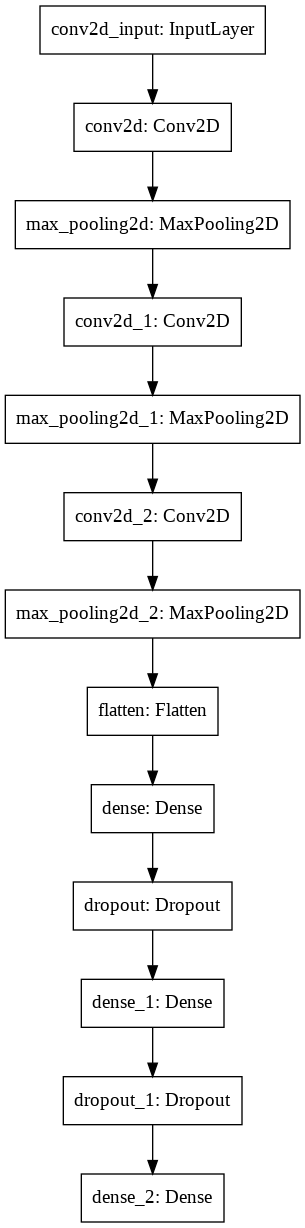

In [ ]:
keras.utils.plot_model(model)


In [ ]:
opt=keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt,
              loss=loss,
              metrics="accuracy")

In [ ]:
model.fit_generator(training_set,
                    epochs=30, 
                    validation_data=test_set,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VAL_STEP)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


ValueError: ignored

## İmageNet

In [ ]:
image_count = 5592
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VAL_STEP = np.ceil(1398/BATCH_SIZE)
print("Steps_per_epoch = ",STEPS_PER_EPOCH)
print("Val_Step = ",VAL_STEP)

Steps_per_epoch =  175.0
Val_Step =  44.0


In [ ]:
inception = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',
                                                 input_shape=(height,width,3),
                                                 include_top = False)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
inception.get_layer(index=236)

In [ ]:


layer = inception.get_layer('mixed6')
x = tf.keras.layers.Flatten()(layer.output)

x=tf.keras.layers.Dense(units=128,activation='relu')(x)
x=tf.keras.layers.Dense(units=64,activation='relu')(x)
x=tf.keras.layers.Dense(units=32,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
out=tf.keras.layers.Activation(activation='sigmoid')(x)



In [ ]:
model=tf.keras.Model(inputs=inception.input,outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [ ]:
my_callback = MyThresholdCallback(threshold=0.93)
history = model.fit_generator(training_set,
                    epochs=15,
                    validation_data=test_set,
                    callbacks=[my_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 62s 1s/step - loss: 0.3578 - accuracy: 0.8439 - val_loss: 0.5015 - val_accuracy: 0.8043
Epoch 2/15
44/44 [==============================] - 62s 1s/step - loss: 0.3262 - accuracy: 0.8593 - val_loss: 0.4645 - val_accuracy: 0.8043
Epoch 3/15
44/44 [==============================] - 62s 1s/step - loss: 0.2969 - accuracy: 0.8641 - val_loss: 0.5229 - val_accuracy: 0.8336
Epoch 4/15
44/44 [==============================] - 62s 1s/step - loss: 0.2724 - accuracy: 0.8802 - val_loss: 0.6474 - val_accuracy: 0.8114
Epoch 5/15
44/44 [==============================] - 62s 1s/step - loss: 0.2528 - accuracy: 0.8913 - val_loss: 0.7183 - val_accuracy: 0.8114
Epoch 6/15
44/44 [==============================] - 62s 1s/step - loss: 0.2384 - accuracy: 0.8989 - val_loss: 0.7340 - val_accuracy: 0.8050
Epoch 7/15
44/44 [==============================] - 62s 1s/step - loss: 0.2178 - accuracy: 0.9080 - val_loss: 0.6950 - val_accuracy: 0.8193
Epoch 8/15
44/44 [==

## Xgboost

In [ ]:
param = {

    "learning_rate": 0.3,
    "n_estimators": 300 ,
    "max_depth": 3,
    "gamma": 1,
    "eval_metric" : "rmse" ,
    'eta': 0.1,                     
    'silent': 1,                    
    'objective': 'binary:logitraw'  ,
    "min_child_weight" :1
}

In [ ]:

trainx,trainy=get_values(training_set_xgb)
testx,testy=get_values(test_set_xgb)
dtrain = xgboost.DMatrix(trainx, label=trainy)
dtest = xgboost.DMatrix(testx, label=testy)



In [ ]:
xgb = xgboost.train(param,dtrain)

In [ ]:
pred=xgb.predict(dtest)
pred=sinif(pred)
metrik(pred,testy)

Accuracy: 0.617143
precision: 0.767974
recall: 0.335714
f1 score: 0.467197
Confusion Matris = 
 [[629  71]
 [465 235]]


In [ ]:
xgb.save_model("xgbmodel")

In [ ]:
predcnn=model.predict_generator(test_set)
metrik(sinif(predcnn),test_set.classes)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.501429
precision: 0.501323
recall: 0.541429
f1 score: 0.520604
Confusion Matris = 
 [[323 377]
 [321 379]]


In [ ]:
pred_together,acc_cnn,acc_xgb,acc_plus=together_metrics(predcnn,pred,test_set.classes)

Accuracy: 0.618571
precision: 0.805147
recall: 0.312857
f1 score: 0.450617
Confusion Matris = 
 [[647  53]
 [481 219]]


In [ ]:
def together_predict(data_xgb,data_cnn,acc_cnn=acc_cnn,acc_xgb=acc_xgb,acc_plus=acc_plus):
  pred_xgb=xgb.predict(data_xgb)
  pred_cnn=model.predict(data_cnn)
  predict=((float (acc_cnn / acc_plus)* pred_cnn)+(float (acc_xgb / acc_plus)*pred_xgb))

  predict=sinif(predict)
  #predict=get_key(predict)
  return predict

NameError: ignored

In [ ]:
xgb

Accuracy: 0.500000
precision: 0.500000
recall: 0.540000
f1 score: 0.519231
Confusion Matris = 
 [[322 378]
 [322 378]]


## Results F1 - Recall - Precision Score & Model Prediction

In [ ]:
model.evaluate(test_set)

44/44 [==============================] - 19s 436ms/step - loss: 0.7675 - accuracy: 0.8512


[0.7675214409828186, 0.8512160181999207]

In [ ]:
print("-----XGBoost metrics-----")
metrik(pred,test_set.labels)
print("-----CNN metrics-----")
metrik(predcnn,test_set.labels)
print("-----CNN and XGBoost metrics-----")
metrik(pred_together,test_set.labels)


-----XGBoost metrics-----
Accuracy: 0.619286
precision: 0.805861
recall: 0.314286
f1 score: 0.452210
Confusion Matris = 
 [[647  53]
 [480 220]]
-----CNN metrics-----
Accuracy: 0.501429
precision: 0.501323
recall: 0.541429
f1 score: 0.520604
Confusion Matris = 
 [[323 377]
 [321 379]]
-----CNN and XGBoost metrics-----
Accuracy: 0.618571
precision: 0.805147
recall: 0.312857
f1 score: 0.450617
Confusion Matris = 
 [[647  53]
 [481 219]]


### İmage Prediction 

In [ ]:
def img_process_cnn(img,h,w):
  print(img)
  img = cv2.imread('{}'.format(img),1)
  print(img.shape)
  img = cv2.resize(img,(h,w))
  res_img = np.reshape(img,(1,h,w,3))
  return img,res_img
def img_process_xgb(img,h,w):
  print(img)
  img = cv2.imread('{}'.format(img),1)
  print(img.shape)
  img = cv2.resize(img,(h,w))
  res_img = np.reshape(img,(h*w))
  return img,res_img

In [ ]:
def val_prediction(img,model):
  result = model.predict(img)
  if result[0][0] == 1:
    prediction = 'normal - 1'
  else:
    prediction = 'anormal - 0'
  
  return prediction

In [ ]:
test_set.class_indices

{'anormal': 0, 'normal': 1}

In [ ]:
def test_prediction(img,model):
  img = np.reshape(img,(1,height,width,3))
  result = model.predict(img)
  if result[0][0] == 1:
    prediction = 'normal - 1'
  else:
    prediction = 'anormal - 0'
  
  return prediction

In [ ]:
model.save('/content/drive/MyDrive/X_ray_acc:0.79-loss:0.4- val_acc:0.7479.pb')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/X_ray_acc:0.79-loss:0.4- val_acc:0.7479.pb/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/X_ray_acc:0.79-loss:0.4- val_acc:0.7479.pb/assets


In [ ]:
y_pred = model.predict(X_test, batch_size=32)
label = np.argmax(y_pred,axis=1)

In [ ]:
xgb.save_model("xgbmodel")

NameError: ignored